# Bi-LSTM model on KaggleCompetition data set 

This model would be only for the text column with a binary target Fake/Not Fake.
This  Bi-LSTM model was built on the first LSTM Model (that was done by Andrii Shchur in 2020. Here is its [article](https://towardsdatascience.com/fake-news-detector-with-deep-learning-approach-part-i-eda-757f5c052)

- The kaggle dataset contains a lot politic topics 
- The Kaggle competition dataset : it is a full open training dataset that contains news articles and their title, author and label (reliable and unreliable)

<img src='https://media.giphy.com/media/l0Iyau7QcKtKUYIda/giphy.gif'>

### <span style="background-color: #FFFF00">In this notebook, I have corrected the preprocessing of the data</span>

## Importing packages 

In [14]:
# Load libraries
import pandas as pd
import numpy as np
import os.path as op
import time
import matplotlib.pyplot as plt
#Loading keras 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
#Loading nltk
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
#Loading sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
#Loading K-folds
from sklearn.model_selection import StratifiedKFold
#Loading the model 
import sys  
sys.path.insert(0, '../../models')
from PY.model4 import get_model

## Paths 

In [4]:
DATA_DIR = '../../../../Data'
CODE_DIR_H5='../../models/H5'
# Create a path for the saving location of the model
MODEL_DIR_H5 = CODE_DIR_H5 + '/model4_Kaggle.h5'

## Loading Data 

In [29]:
# Load train data
train = pd.read_csv(op.join(DATA_DIR, 'Kaggle_competition/Claims_to_work_with/claims.csv'))
train 

id                                              title  \
0          0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1          1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2          2                  Why the Truth Might Get You Fired   
3          3  15 Civilians Killed In Single US Airstrike Hav...   
4          4  Iranian woman jailed for fictional unpublished...   
...      ...                                                ...   
20795  20795  Rapper T.I.: Trump a ’Poster Child For White S...   
20796  20796  N.F.L. Playoffs: Schedule, Matchups and Odds -...   
20797  20797  Macy’s Is Said to Receive Takeover Approach by...   
20798  20798  NATO, Russia To Hold Parallel Exercises In Bal...   
20799  20799                          What Keeps the F-35 Alive   

                                          author  \
0                                  Darrell Lucus   
1                                Daniel J. Flynn   
2                             Consortiumnews.com   
3                                Jessica Purkiss   
4                                 Howard Portnoy   
...                                          ...   
20795                              Jerome Hudson   
20796                           Benjamin Hoffman   
20797  Michael J. de la Merced and Rachel Abrams   
20798                                Alex Ansary   
20799                              David Swanson   

                                                    text  label  
0      House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1      Ever get the feeling your life circles the rou...      0  
2      Why the Truth Might Get You Fired October 29, ...      1  
3      Videos 15 Civilians Killed In Single US Airstr...      1  
4      Print \nAn Iranian woman has been sentenced to...      1  
...                                                  ...    ...  
20795  Rapper T. I. unloaded on black celebrities who...      0  
20796  When the Green Bay Packers lost to the Washing...      0  
20797  The Macy’s of today grew from the union of sev...      0  
20798  NATO, Russia To Hold Parallel Exercises In Bal...      1  
20799    David Swanson is an author, activist, journa...      1  

[20800 rows x 5 columns]

In [6]:
# Find Na 
train.isnull().sum()

id           0
title        0
author    1957
text         0
label        0
dtype: int64

In [7]:
#Get the Depndent feature
X_train=train.drop('label',axis=1)
y_train=train['label']

In [8]:
# set vocabulary size
vo_size=500
messages=X_train.copy()
messages.reset_index(inplace=True)

In [9]:
len(messages), len(y_train)

(20800, 20800)

In [10]:
# Dataset Preprocessing
cmp=0
ps =PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    print("Status: %s / %s" %(i, len(messages)), end="\r")
    review = re.sub('[^a-zA-Z]', ' ',messages['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    if review :
        review = ' '.join(review)
        corpus.append(review)
        y_train[i]=y_train[i]
    else :
        cmp=cmp+1
        y_train[i]=np.nan
y_train.reset_index()

Status: 21 / 20800

C:\Users\CBS Compter\anaconda3\envs\tensorflow7\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


Status: 65 / 20800

C:\Users\CBS Compter\anaconda3\envs\tensorflow7\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\CBS Compter\anaconda3\envs\tensorflow7\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


index  label
0          0    1.0
1          1    0.0
2          2    1.0
3          3    1.0
4          4    1.0
...      ...    ...
20795  20795    0.0
20796  20796    0.0
20797  20797    0.0
20798  20798    1.0
20799  20799    1.0

[20800 rows x 2 columns]

In [11]:
print('the number of lines that could not be preprocessed',cmp)

the number of lines that could not be preprocessed 163


In [12]:
print("We need to delete those",y_train.isnull().sum(),"lines from the label column")
y_train=y_train.dropna()
y_train.astype('Int64')

We need to delete those 163 lines from the label column


0        1
1        0
2        1
3        1
4        1
        ..
20795    0
20796    0
20797    0
20798    1
20799    1
Name: label, Length: 20637, dtype: Int64

In [15]:
# one hot representation
onehot_rep = [one_hot(words, vo_size) for words in corpus]

In [16]:
# pad_sequences
sent_length = 1000
embedded_doc=pad_sequences(onehot_rep, padding='pre', maxlen=sent_length)
print(embedded_doc)

[[  0   0   0 ... 133  56 205]
 [  0   0   0 ... 231 380 435]
 [  0   0   0 ... 164 319 259]
 ...
 [  0   0   0 ... 451 428  10]
 [  0   0   0 ... 459 435 238]
 [  0   0   0 ... 425 108  20]]


In [17]:
embedding_vector_feature = 100

In [18]:
# check shape 
len(embedded_doc),y_train.shape

(20637, (20637,))

In [19]:
# final data for NN
X_final=np.array(embedded_doc)
y_final=np.array(y_train)
X_final.shape,y_final.shape

((20637, 20), (20637,))

## Training  the model 

In [20]:
start=time.time()
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores1 = []
cvscores2 = []
cvscores3 = []
cvscores4 = []
num_iter=0

for train, test in kfold.split(X_final, y_final):
    num_iter=num_iter+1
    model=get_model(vo_size,embedding_vector_feature,sent_length)
    # Fit the model
    history=model.fit(X_final[train], y_final[train], epochs=10, batch_size=256,verbose=0)
    # evaluate the model
    scores = model.evaluate(X_final[test], y_final[test], verbose=0)
    print("------subset number", num_iter,"------")
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores1.append(scores[1] * 100)
    print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))
    cvscores2.append(scores[2] * 100)
    print("%s: %.2f%%" % (model.metrics_names[3], scores[3]*100))
    cvscores3.append(scores[3] * 100)
    print("%s: %.2f%%" % (model.metrics_names[4], scores[4]*100))
    cvscores4.append(scores[4] * 100)
print("--------------------------------------------" )   
print("accuracy","%.2f%% (+/- %.2f%%)" % (np.mean(cvscores1), np.std(cvscores1)))
print("precision","%.2f%% (+/- %.2f%%)" % (np.mean(cvscores2), np.std(cvscores2)))
print("recall","%.2f%% (+/- %.2f%%)" % (np.mean(cvscores3), np.std(cvscores3)))
print("f1-mesure","%.2f%% (+/- %.2f%%)" % (np.mean(cvscores4), np.std(cvscores4)))
end=time.time()

------subset number 1 ------
accuracy: 90.89%
precision_mesure: 88.69%
recall_mesure: 93.09%
f1_mesure: 90.57%
------subset number 2 ------
accuracy: 92.54%
precision_mesure: 89.28%
recall_mesure: 96.71%
f1_mesure: 92.63%
------subset number 3 ------
accuracy: 90.70%
precision_mesure: 88.37%
recall_mesure: 93.74%
f1_mesure: 90.67%
------subset number 4 ------
accuracy: 91.67%
precision_mesure: 87.82%
recall_mesure: 95.92%
f1_mesure: 91.49%
------subset number 5 ------
accuracy: 91.91%
precision_mesure: 91.79%
recall_mesure: 91.79%
f1_mesure: 91.57%
------subset number 6 ------
accuracy: 89.24%
precision_mesure: 86.71%
recall_mesure: 92.36%
f1_mesure: 89.16%
------subset number 7 ------
accuracy: 90.79%
precision_mesure: 85.62%
recall_mesure: 97.68%
f1_mesure: 91.00%
------subset number 8 ------
accuracy: 90.98%
precision_mesure: 87.29%
recall_mesure: 95.68%
f1_mesure: 91.08%
------subset number 9 ------
accuracy: 91.37%
precision_mesure: 87.42%
recall_mesure: 96.93%
f1_mesure: 91.63%
-

In [22]:
# Save the model
model.save(MODEL_DIR_H5)
model.summary() 

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 20, 10)            5000      
_________________________________________________________________
bidirectional_9 (Bidirection (None, 200)               88800     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 201       
Total params: 94,001
Trainable params: 94,001
Non-trainable params: 0
_________________________________________________________________


In [23]:
print('time of training' , end-start)

time of training 1095.0374891757965


## Evaluation metrics

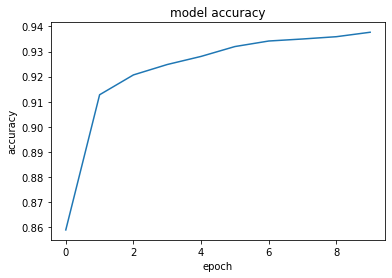

In [24]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

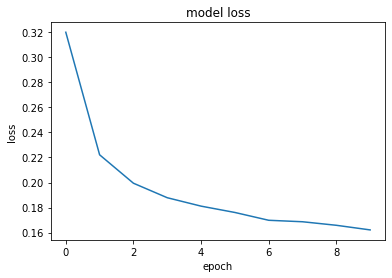

In [25]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

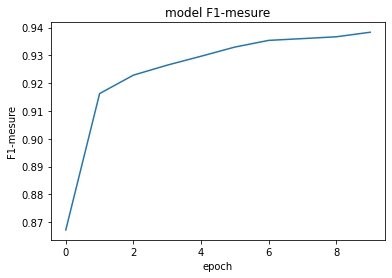

In [26]:
# summarize history for f1-mesure
plt.plot(history.history['f1_mesure'])
plt.title('model F1-mesure')
plt.ylabel('F1-mesure')
plt.xlabel('epoch')
plt.show()

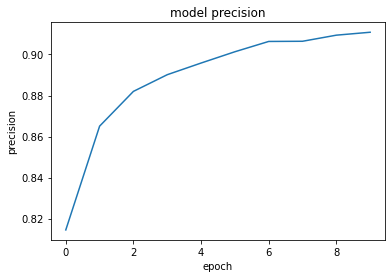

In [27]:
# summarize history for precision
plt.plot(history.history['precision_mesure'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.show()

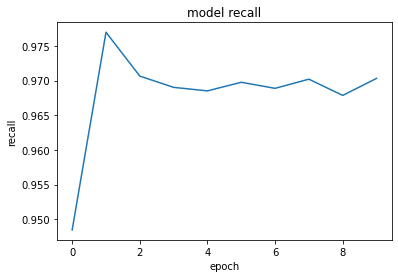

In [28]:
# summarize history for recall
plt.plot(history.history['recall_mesure'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.show()